# Citibike ML
In this example notebook we show a baseline model using ARIMA.  This provides a starting point for comparison.

### 1. Load the Credentials


In [1]:
from dags.snowpark_connection import snowpark_connect
session, state_dict = snowpark_connect()

### 2. Load Data

In [2]:
import snowflake.snowpark as snp
from snowflake.snowpark import functions as F
from snowflake.snowpark import types as T

import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
trips_table_name = state_dict['trips_table_name']

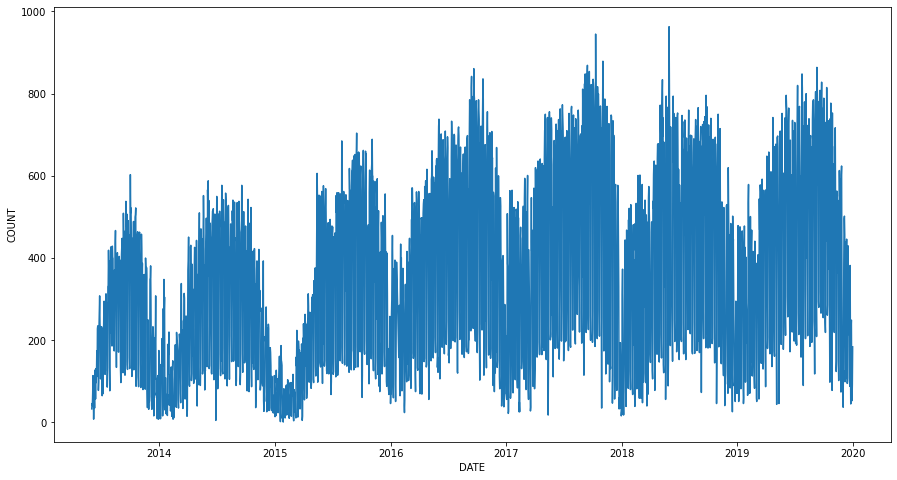

In [4]:
snowdf = session.table(trips_table_name)

top_stations = snowdf.filter(F.col('START_STATION_ID').is_not_null()) \
                    .groupBy('START_STATION_ID') \
                    .count() \
                    .sort('COUNT', ascending=False) \
                    .toPandas()['START_STATION_ID'].values.tolist()

df = snowdf.filter(F.col('START_STATION_ID') == top_stations[0]) \
      .withColumn('DATE', 
                  F.call_builtin('DATE_TRUNC', ('DAY', F.col('STARTTIME')))) \
      .groupBy('DATE') \
      .count() \
      .sort('DATE').toPandas()

plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='DATE', y='COUNT', data=df)

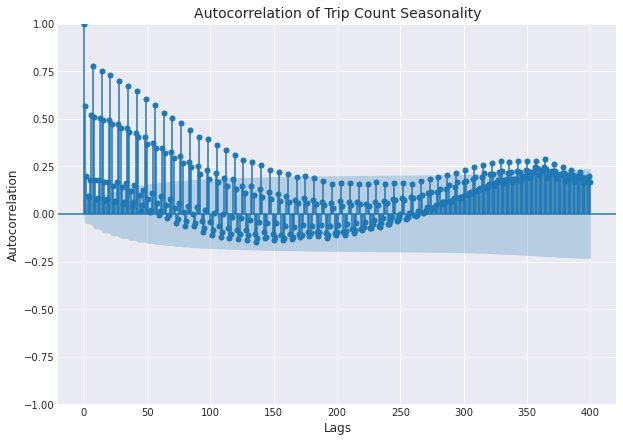

In [5]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rc("figure", figsize=(10, 7))
plot_acf(df['COUNT'], lags=400)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of Trip Count Seasonality', fontsize=14)
plt.show()

We can definitely see the strong annual seasonality.  Lets look closer at the daily and weekly lag.

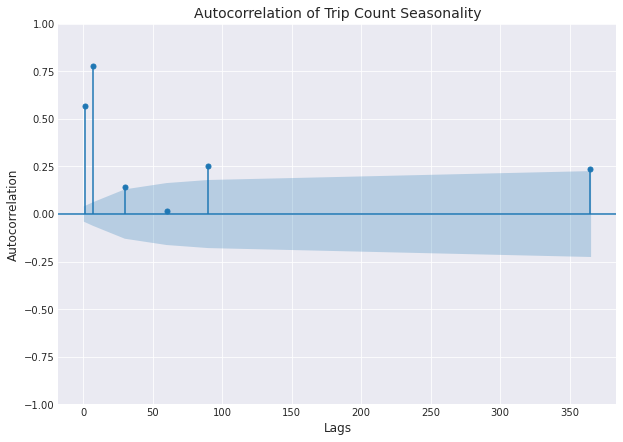

In [6]:
plt.rc("figure", figsize=(10, 7))
plot_acf(df['COUNT'], lags=[1, 7, 30, 60, 90, 365])
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of Trip Count Seasonality', fontsize=14)
plt.show()

### Baseline Model
Lets build a baseline with ARIMA since we already have statsmodels imported

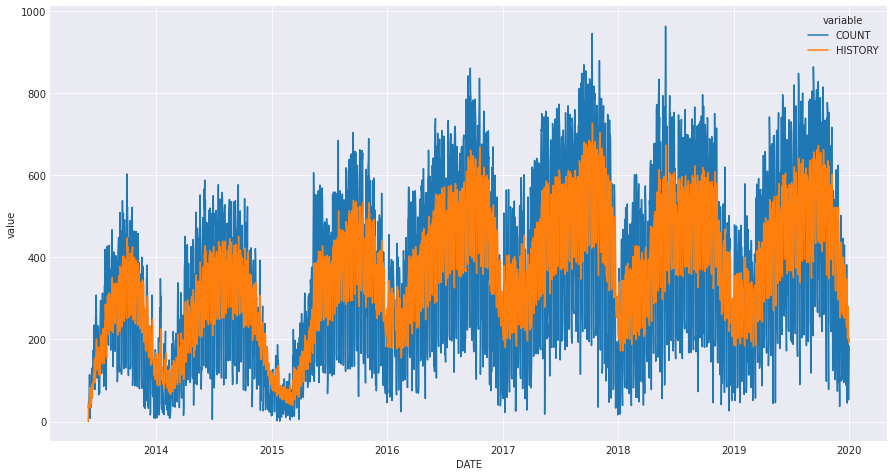

In [7]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df['COUNT'],order=(1,1,1))
history=model.fit()
df['HISTORY']=history.predict(start=0, end=len(df))
plt.figure(figsize=(15, 8))
df1 = pd.melt(df, id_vars=['DATE'], value_vars=['COUNT', 'HISTORY'])
ax = sns.lineplot(x='DATE', y='value', hue='variable', data=df1)

In [8]:
print("P-Value = ", adfuller(df['COUNT'].dropna(), autolag = 'AIC')[1])

P-Value =  0.10729530652110181


With a p-value greater than .05 we know that the trend is non-trivial.

<AxesSubplot:title={'center':'original'}>

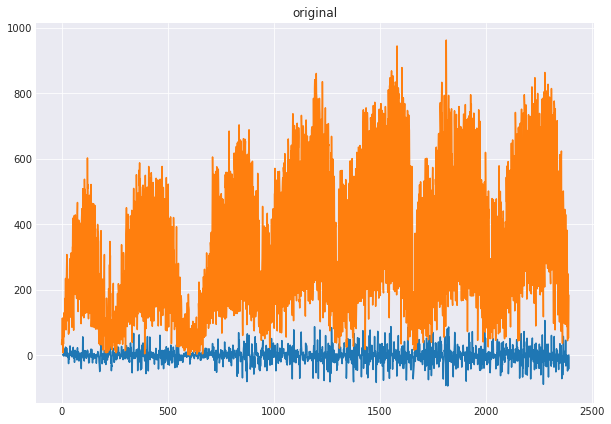

In [9]:
rolling_mean = df['COUNT'].rolling(window = 7).mean()
df['STATIONARY'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
df['STATIONARY'].plot(title='Differenced');
ax2 = plt.subplot()
df['COUNT'].plot(title='original')

In [10]:
print("P-Value = ", adfuller(df['STATIONARY'].dropna(), autolag = 'AIC')[1])

P-Value =  4.9207800886029545e-21


By differencing with the rolling mean we can stationarize the series.  In order to account for this trend we can create an exogenous signal.

In [ ]:
# import numpy as np
# exog = pd.DataFrame(pd.PeriodIndex(df['DATE'], freq='D')).set_index('DATE')
# exog['f1'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
# exog['f2'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
# exog['f3'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
# exog['f4'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
# exog = exog.reset_index()
# exog = exog.drop(columns=['DATE'])

...or use we can use the `trend=` flag in ARIMA.

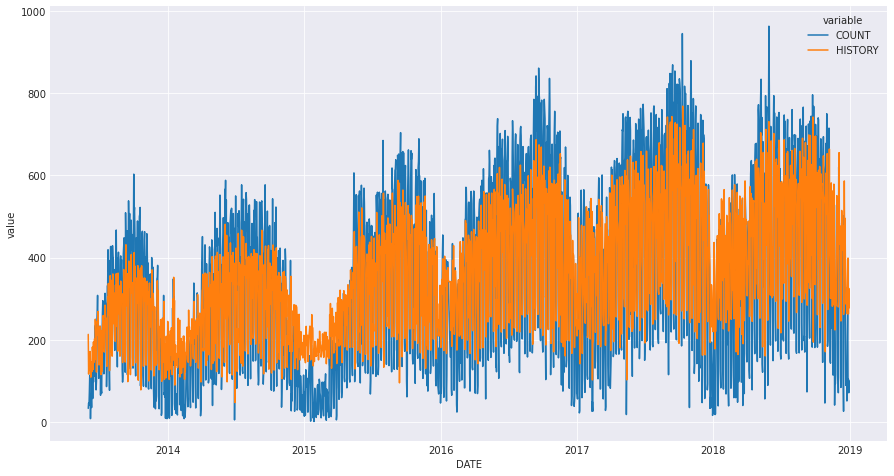

In [11]:
model=ARIMA(endog=df['COUNT'][:-365], trend='ct', order=(1,0,1))
history=model.fit()
df['HISTORY']=history.predict(start=0, end=len(df))
plt.figure(figsize=(15, 8))
df1 = pd.melt(df[:-365], id_vars=['DATE'], value_vars=['COUNT', 'HISTORY'])
ax = sns.lineplot(x='DATE', y='value', hue='variable', data=df1)

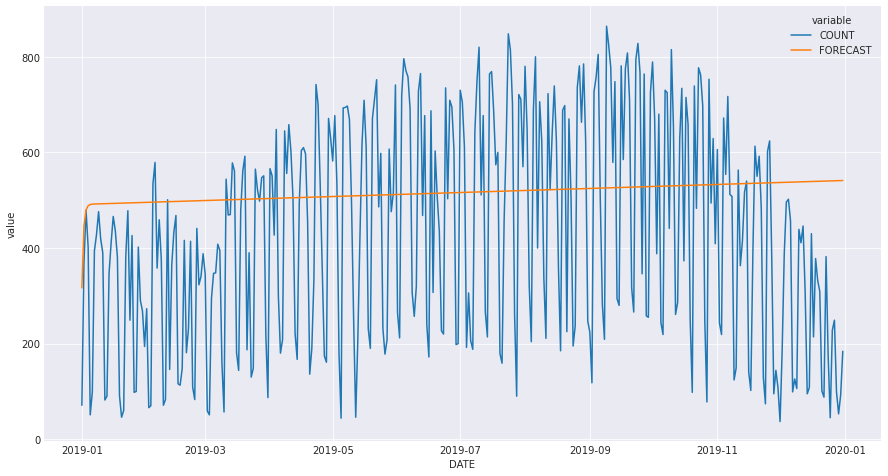

In [12]:
from sklearn.metrics import mean_squared_error
dftest=pd.DataFrame()
dftest['DATE']=df['DATE'][-365:]
dftest['COUNT']=df['COUNT'][-365:]
dftest['FORECAST']=history.forecast(steps=365)
plt.figure(figsize=(15, 8))
df1 = pd.melt(dftest, id_vars=['DATE'], value_vars=['COUNT', 'FORECAST'])
ax = sns.lineplot(x='DATE', y='value', hue='variable', data=df1)

error = mean_squared_error(dftest['COUNT'], dftest['FORECAST'])


In [13]:
print("ARIMA Error is: "+str(error))

ARIMA Error is: 59982.06865718524
